# Fast Personalized Pagerank Implementation (Moler PageRank)
I needed a fast PageRank for Wikisim project, it has to be fast enough that can run in real time on relatively large graphs. Networkx was the obvious
I implemented two versions of the algorithm in Python, both inspired  by the sparse fast solutions given in [**Cleve Moler**](https://en.wikipedia.org/wiki/Cleve_Moler)'s book, [*Experiments with MATLAB*](http://www.mathworks.com/moler/index_ncm.html). The power method is much faster with enough precision for our task. Our benchmarsk shows that this implementation is **faster than both Networkx and iGraph** implementationa magnititude of times. 

## Personalized Pagerank
I modified the algorithm a little bit to be able to calculate **personalized Pagerank** as well. 

## Input Format
The input is a 2d array, each row of the array is an edge of the graph $[[a,b], [c,d]]$, $a$ and $b$ are the node numbers. The **personalization vector** is probability distribution over the nodes, a.k.a **teleporting vector**.

## Comparison with Popular Python Implementations: Networkx and iGraph
Both of the implementation (Exact Solution and PowerMethod) are much faster than their correspondent method in NetworkX. 

#

In [2]:
%load_ext pycodestyle_magic

In [50]:
%%writefile ../src/pagerank.py
"""Two fast implementations of PageRank: 
    An exact solution using a sparse linear system solver, and an a power method approximation. 
    Both solutions are taking full advantage of sparse matrix calculations.
    
    [Reference]:
    Cleve Moler. 2011. Experiments with MATLAB (Electronic ed.). MathWorks, Inc.
"""
# uncomment
from __future__ import division

import scipy as sp
import scipy.sparse as sprs
import scipy.spatial
import scipy.sparse.linalg

__author__ = "Armin Sajadi"
__copyright__ = "Copyright 2015, The Wikisim Project"
__email__ = "asajadi@gmail.com"


def pagerank(G, p=0.85,
             personalize=None, reverse=False):
    """ Calculates pagerank given a csr graph

    Inputs:
    -------

    G: a csr graph.
    p: damping factor
    personlize: if not None, should be an array with the size of the nodes
                containing probability distributions.
                It will be normalized automatically
    reverse: If true, returns the reversed-pagerank

    outputs
    -------

    Pagerank Scores for the nodes

    """
    # In Moler's algorithm, $G_{ij}$ represents the existences of an edge
    # from node $j$ to $i$, while we have assumed the opposite!
    if not reverse:
        G = G.T

    n, _ = G.shape
    c = sp.asarray(G.sum(axis=0)).reshape(-1)

    k = c.nonzero()[0]

    D = sprs.csr_matrix((1 / c[k], (k, k)), shape=(n, n))

    if personalize is None:
        personalize = sp.ones(n)
    personalize = personalize.reshape(n, 1)
    e = (personalize / personalize.sum()) * n

    I = sprs.eye(n)
    x = sprs.linalg.spsolve((I - p * G.dot(D)), e)

    x = x / x.sum()
    return x


def pagerank_power(G, p=0.85, max_iter=100,
                   tol=1e-06, personalize=None, reverse=False):
    """ Calculates pagerank given a csr graph

    Inputs:
    -------
    G: a csr graph.
    p: damping factor
    max_iter: maximum number of iterations
    personlize: if not None, should be an array with the size of the nodes
                containing probability distributions.
                It will be normalized automatically.
    reverse: If true, returns the reversed-pagerank

    Returns:
    --------
    Pagerank Scores for the nodes

    """
    # In Moler's algorithm, $G_{ij}$ represents the existences of an edge
    # from node $j$ to $i$, while we have assumed the opposite!
    if not reverse:
        G = G.T

    n, _ = G.shape
    c = sp.asarray(G.sum(axis=0)).reshape(-1)

    k = c.nonzero()[0]

    D = sprs.csr_matrix((1 / c[k], (k, k)), shape=(n, n))

    if personalize is None:
        personalize = sp.ones(n)
    personalize = personalize.reshape(n, 1)
    e = (personalize / personalize.sum()) * n

    z = (((1 - p) * (c != 0) + (c == 0)) / n)[sp.newaxis, :]
    G = p * G.dot(D)

    x = e / n
    oldx = sp.zeros((n, 1))

    iteration = 0

    while sp.linalg.norm(x - oldx) > tol:
        oldx = x
        x = G.dot(x) + e.dot(z.dot(x))
        iteration += 1
        if iteration >= max_iter:
            break
    x = x / sum(x)

    return x.reshape(-1)


Overwriting ../src/pagerank.py


# Testing the algorithm

In [51]:
%%writefile ../test/pagerank_test.py

import os
import sys
import scipy as sp
import scipy.sparse as sparse
from numpy.testing import assert_allclose
import unittest

sys.path.insert(
    0,
    os.path.abspath(
        os.path.join(
            os.path.dirname(__file__),
            '..')))

from src.pagerank import pagerank_power
from src.pagerank import pagerank

class TestMolerPageRank(unittest.TestCase):
    def setUp(self):
        # ---G1---
        n1 = 5
        rows1 = [0, 1, 2, 2, 2, 3, 3, 4, 4, 4]
        cols1 = [1, 2, 1, 3, 4, 0, 2, 0, 2, 3]
        data1 = [
            0.4923, 0.0999, 0.2132, 0.0178, 0.5694,
            0.0406, 0.2047, 0.861, 0.3849, 0.4829]

        self.p1 = 0.83
        self.personalize1 = sp.array([0.6005, 0.1221, 0.2542, 0.4778, 0.4275])
        self.G1 = sparse.csr_matrix((data1, (rows1, cols1)), shape=(n1, n1))
        self.pr1 = sp.array([0.1592, 0.2114, 0.3085, 0.1, 0.2208])

        # ---G2---
        n2 = 10
        rows2 = [2, 2, 4, 5, 5, 5, 6, 6, 9, 9]
        cols2 = [4, 5, 5, 3, 4, 9, 1, 2, 2, 4]
        data2 = [
            0.4565, 0.2861, 0.573, 0.0025, 0.4829,
            0.3866, 0.3041, 0.3407, 0.2653, 0.8079]
        self.G2 = sparse.csr_matrix((data2, (rows2, cols2)), shape=(n2, n2))
        self.personalize2 = sp.array([0.8887, 0.6491, 0.7843, 0.7103, 0.7428,
                                      0.6632, 0.7351, 0.3006, 0.8722, 0.1652])
        self.p2 = 0.92
        self.pr2 = sp.array([0.0234, 0.0255, 0.0629, 0.0196, 0.3303,
                             0.3436, 0.0194, 0.0079, 0.023, 0.1445])

        # ---G3---
        n3 = 5
        rows3 = [2]
        cols3 = [4]
        data3 = [0.5441]
        self.G3 = sparse.csr_matrix((data3, (rows3, cols3)), shape=(n3, n3))

        self.personalize3 = sp.array([0.0884, 0.2797, 0.3093, 0.5533, 0.985])
        self.p3 = 0.81
        self.pr3 = sp.array([0.0358, 0.1134, 0.1254, 0.2244, 0.501])

        # ---G4---
        n4 = 5
        rows4 = []
        cols4 = []
        data4 = []
        self.G4 = sparse.csr_matrix((data4, (rows4, cols4)), shape=(n4, n4))

        self.personalize4 = sp.array([0.2534, 0.8945, 0.9562, 0.056, 0.9439])
        self.p4 = 0.70
        self.pr4 = sp.array([0.0816, 0.2882, 0.3081, 0.018, 0.3041])

        # ---G5---
        n5 = 0
        rows5 = []
        cols5 = []
        data5 = []
        self.G5 = sparse.csr_matrix((data5, (rows5, cols5)), shape=(n5, n5))

        self.personalize5 = sp.array([])
        self.p5 = 0.70
        self.pr5 = sp.array([])

    def test_pagerank_1(self):
        calculated_pagerank = pagerank(self.G1, p=self.p1,
                                       personalize=self.personalize1)
        assert_allclose(calculated_pagerank, self.pr1, rtol=0, atol=1e-04)

    def test_pagerank_2(self):

        calculated_pagerank = pagerank(self.G2, p=self.p2,
                                       personalize=self.personalize2)
        assert_allclose(calculated_pagerank, self.pr2, rtol=0, atol=1e-04)

    def test_single_edge(self):
        calculated_pagerank = pagerank(self.G3, p=self.p3,
                                       personalize=self.personalize3)
        assert_allclose(calculated_pagerank, self.pr3, rtol=0, atol=1e-04)

    def test_zero_edge(self):
        calculated_pagerank = pagerank(self.G4, p=self.p4,
                                       personalize=self.personalize4)
        assert_allclose(calculated_pagerank, self.pr4, rtol=0, atol=1e-04)

    def test_empty_graph(self):
        calculated_pagerank = pagerank(self.G5, p=self.p5,
                                       personalize=self.personalize5)
        self.assertEqual(calculated_pagerank.size, 0)

    def test_power_pagerank_1(self):
        calculated_pagerank = pagerank_power(self.G1, p=self.p1,
                                             personalize=self.personalize1)
        assert_allclose(calculated_pagerank, self.pr1, rtol=0, atol=1e-04)

    def test_power_pagerank_2(self):

        calculated_pagerank = pagerank_power(self.G2, p=self.p2,
                                             personalize=self.personalize2)
        assert_allclose(calculated_pagerank, self.pr2, rtol=0, atol=1e-04)

    def test_power_single_edge(self):
        calculated_pagerank = pagerank_power(self.G3, p=self.p3,
                                             personalize=self.personalize3)
        assert_allclose(calculated_pagerank, self.pr3, rtol=0, atol=1e-04)

    def test_power_zero_edge(self):
        calculated_pagerank = pagerank_power(self.G4, p=self.p4,
                                             personalize=self.personalize4)
        assert_allclose(calculated_pagerank, self.pr4, rtol=0, atol=1e-04)

    def test_power_empty_graph(self):
        calculated_pagerank = pagerank_power(self.G5, p=self.p5,
                                             personalize=self.personalize5)
        self.assertEqual(calculated_pagerank.size, 0)


#             assert_array_almost_equal(Ynx,  Yml, decimal = 5)
if __name__ == '__main__':
    unittest.main()


Overwriting ../test/pagerank_test.py


In [49]:
!python -m unittest ..test.pagerank_test
#!python ../test/pagerank_test.py


Traceback (most recent call last):
  File "/anaconda3/envs/general/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/envs/general/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/envs/general/lib/python3.7/unittest/__main__.py", line 18, in <module>
    main(module=None)
  File "/anaconda3/envs/general/lib/python3.7/unittest/main.py", line 100, in __init__
    self.parseArgs(argv)
  File "/anaconda3/envs/general/lib/python3.7/unittest/main.py", line 147, in parseArgs
    self.createTests()
  File "/anaconda3/envs/general/lib/python3.7/unittest/main.py", line 159, in createTests
    self.module)
  File "/anaconda3/envs/general/lib/python3.7/unittest/loader.py", line 220, in loadTestsFromNames
    suites = [self.loadTestsFromName(name, module) for name in names]
  File "/anaconda3/envs/general/lib/python3.7/unittest/loader.py", line 220, in <listcomp>
    suites = [self.loadTestsFromName(nam

In [52]:
!python  ../test/pagerank_test.py

/anaconda3/envs/general/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
..........
----------------------------------------------------------------------
Ran 10 tests in 0.054s

OK


In [59]:
!pip install python-igraph

    100% |████████████████████████████████| 378kB 4.4MB/s ta 0:00:011   54% |█████████████████▍              | 204kB 10.1MB/s eta 0:00:01
  Stored in directory: /Users/sajadi/Library/Caches/pip/wheels/41/d6/02/34eebae97e25f5b87d60f4c0687e00523e3f244fa41bc3f4a7
Successfully built python-igraph


# Benchmarking

To avoid the clutter, we only visualize the fastest method from each implementation, that is: 

- `networkx.pagerank_scipy`
- Latest implementation of  `iGraph.personalized_pagerank` (PRPACK)
- Our `pagerank_power` 


In [63]:
import scipy as sp
import timeit
import os
import sys
import random
import igraph
import networkx as nx
sys.path.insert(0, '..')
from src.pagerank import pagerank
from src.pagerank import pagerank_power


def get_random_graph(
        min_size=100,
        max_size=300,
        min_sparsity=0.1,
        max_sparsity=0.5):
    ''' Creates a random graph and a teleport vector and output them
        in different formats for different algorithms

    Inputs
    ------

    min_size and max_size: The size of the graph will be a random number
        in the range of (min_size, max_size)
    min_sparsity and max_sparsity: The sparcity of the graph
        will be a random number in the range of (min_sparsity, max_sparsity)

    Returns
    -------

    nxG: A random Graph for NetworkX
    A: The equivallent csr Adjacency matrix, for our pagerank
    iG: The equivallent iGraph
    personalize_vector: Personalization probabily vector
    personalize_dict: Personalization probabily vector,
                    in the form of a dictionary for NetworkX

    '''
    G_size = random.randint(min_size, max_size)
    p = random.uniform(min_sparsity, max_sparsity)
    nxG = nx.fast_gnp_random_graph(G_size, p, seed=None, directed=True)
    for e in nxG.edges():
        nxG[e[0]][e[1]]['weight'] = sp.rand()

    A = nx.to_scipy_sparse_matrix(nxG)

    iG = igraph.Graph(list(nxG.edges()), directed=True)
    iG.es['weight'] = A.data

    personalize_vector = sp.random.random(G_size)
    personalize_dict = dict(enumerate(personalize_vector.reshape(-1)))
    return nxG, A, iG, personalize_vector, personalize_dict


n = 5
number_of_graphs = 20

size_vector = sp.zeros(number_of_graphs)
netx_pagerank_times = sp.zeros(number_of_graphs)
netx_pagerank_times_numpy = sp.zeros(number_of_graphs)
netx_pagerank_times_scipy = sp.zeros(number_of_graphs)
pagerank_times = sp.zeros(number_of_graphs)
pagerank_times_power = sp.zeros(number_of_graphs)
ig_pagerank_times = sp.zeros(number_of_graphs)

damping_factor = 0.85
tol = 1e-3


for i in range(number_of_graphs):
    nxG, A, iG, personalize_vector, personalize_dict = get_random_graph(
        min_size=100, max_size=1000)
    size_vector[i] = nxG.number_of_edges()

    netx_pagerank_times[i] = timeit.timeit(
        lambda: nx.pagerank(nxG, alpha=damping_factor, tol=tol),
        number=n) / n
    netx_pagerank_times_numpy[i] = timeit.timeit(
        lambda: nx.pagerank_numpy(nxG, alpha=damping_factor),
        number=n) / n
    netx_pagerank_times_scipy[i] = timeit.timeit(
        lambda: nx.pagerank_scipy(nxG, alpha=damping_factor, tol=tol),
        number=n) / n
    ig_pagerank_times[i] = timeit.timeit(
        lambda: iG.personalized_pagerank(directed=True,
                                         damping=damping_factor,
                                         weights=iG.es['weight'],
                                         implementation="prpack"),
        number=n) / n
    pagerank_times[i] = timeit.timeit(
        lambda: pagerank(A, p=damping_factor),
        number=n) / n
    pagerank_times_power[i] = timeit.timeit(
        lambda: pagerank_power(A, p=damping_factor, tol=tol),
        number=n) / n


argsort = size_vector.argsort()

size_vector_sorted = size_vector[argsort]

netx_pagerank_times_sorted = netx_pagerank_times[argsort]
netx_pagerank_times_numpy_sorted = netx_pagerank_times_numpy[argsort]
netx_pagerank_times_scipy_sorted = netx_pagerank_times_scipy[argsort]

pagerank_times_sorted = pagerank_times[argsort]
pagerank_times_power_sorted = pagerank_times_power[argsort]

ig_pagerank_times_sorted = ig_pagerank_times[argsort]


print("Done")


Done


# Plotting

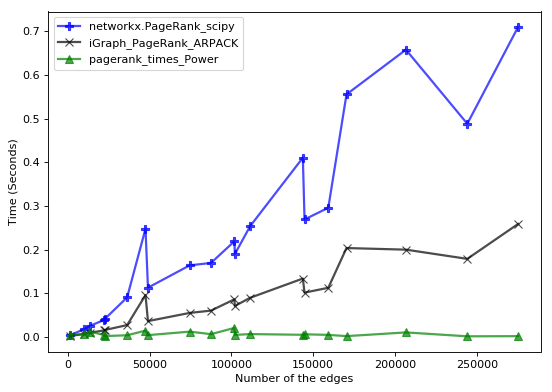

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(num=None, figsize=(7, 5), dpi=80, facecolor='w', edgecolor='k')


# plt.plot(size_vector_sorted, netx_pagerank_times_sorted,
#          'o-', ms=8, lw=2, alpha=0.7, color='cyan',
#          label='networkx.PageRank')
# plt.plot(size_vector_sorted, netx_pagerank_times_numpy_sorted,
#          'v-', ms=8, lw=2, alpha=0.7, color='magenta',
#          label='networkx.PageRank_numpy')

plt.plot(size_vector_sorted, netx_pagerank_times_scipy_sorted,
         'P-', ms=8, lw=2, alpha=0.7, color='blue',
         label='networkx.PageRank_scipy')

plt.plot(size_vector_sorted, ig_pagerank_times_sorted,
         'x-', ms=8, lw=2, alpha=0.7, color='black',
         label='iGraph_PageRank_ARPACK')

# plt.plot(size_vector_sorted, pagerank_times,
#          '*-', ms=8, lw=2, alpha=0.7, color='red',
#          label='pagerank_times')
plt.plot(size_vector_sorted, pagerank_times_power,
         '^-', ms=8, lw=2, alpha=0.7, color='green',
         label='pagerank_times_Power')


plt.xlabel('Number of the edges')
plt.ylabel('Time (Seconds)')


plt.tight_layout()
plt.legend(loc=2)
plt.savefig('pagerank_exact.eps')
plt.show()
